# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [ ]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2024-10-08 09:40:41--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   216KB/s    in 1m 51s  

2024-10-08 09:42:34 (215 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



#### Импорт необходимых библиотек

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Softmax, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

## Обработка входных данных


Выполним нормализацию и приведение изображений к одному размеру. Также разобьем
данные на обучающую и тестовую выборки, используя стратификацию для сохранения пропорций классов.

In [ ]:
def get_class_names(data_dir):
    return sorted(os.listdir(data_dir))

def load_and_preprocess_data(data_dir, target_size):
    images = []
    labels = []
    class_names = get_class_names(data_dir)
    class_to_index = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            class_label = class_to_index[class_name]
            for file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, file)
                image = load_img(image_path, target_size=target_size)
                image = img_to_array(image) / 255.0
                images.append(image)
                labels.append(class_label)

    return class_names, np.array(images), np.array(labels), len(class_names)

data_dir = 'petfaces'
target_size = (256, 256)

class_names, images, labels, num_classes = load_and_preprocess_data(data_dir, target_size)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)


Количество классов / категорий

In [ ]:
num_classes

35

Создадим списки с индексами классов для кошек и собак

In [ ]:
cats, dogs = list(), list()

for i in range(len(class_names)):
    if class_names[i].startswith('cat'):
        cats.append(i)
    if class_names[i].startswith('dog'):
        dogs.append(i)

## Обучение модели

Будем использовать сверточную нейронную сеть с аугментацией данных, в которой будут выполняться операции случайного отражения по горизонтали, случайного поворота и случайного масштабирования изображения. Архитектура нейросети: [Свертка Conv2D + Пулинг MaxPooling2D] x 3 -> Flatten -> Dropout -> Полносвязный слой Dense -> Softmax.  

In [ ]:
def build_data_augmentation(target_size):
    return Sequential([
        RandomFlip("horizontal", input_shape=(target_size[0], target_size[1], 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ])

model = Sequential([
    build_data_augmentation(target_size),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(num_classes),
    Softmax()
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)       

In [ ]:
top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')

model.compile(optimizer=Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', top3_acc])

h = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
81/81 [==============================] - 24s 274ms/step - loss: 3.2997 - accuracy: 0.1048 - top_3_accuracy: 0.2481 - val_loss: 2.8665 - val_accuracy: 0.1944 - val_top_3_accuracy: 0.4090
Epoch 2/10
81/81 [==============================] - 21s 260ms/step - loss: 2.5972 - accuracy: 0.2812 - top_3_accuracy: 0.5078 - val_loss: 2.3023 - val_accuracy: 0.3297 - val_top_3_accuracy: 0.6034
Epoch 3/10
81/81 [==============================] - 21s 259ms/step - loss: 2.2524 - accuracy: 0.3579 - top_3_accuracy: 0.6086 - val_loss: 2.0773 - val_accuracy: 0.4090 - val_top_3_accuracy: 0.6641
Epoch 4/10
81/81 [==============================] - 21s 264ms/step - loss: 2.0167 - accuracy: 0.4299 - top_3_accuracy: 0.6819 - val_loss: 1.9332 - val_accuracy: 0.4448 - val_top_3_accuracy: 0.6936
Epoch 5/10
81/81 [==============================] - 21s 264ms/step - loss: 1.8277 - accuracy: 0.4782 - top_3_accuracy: 0.7060 - val_loss: 1.7718 - val_accuracy: 0.4837 - val_top_3_accuracy: 0.7434
Epoch 6/10
81/8

## Результаты

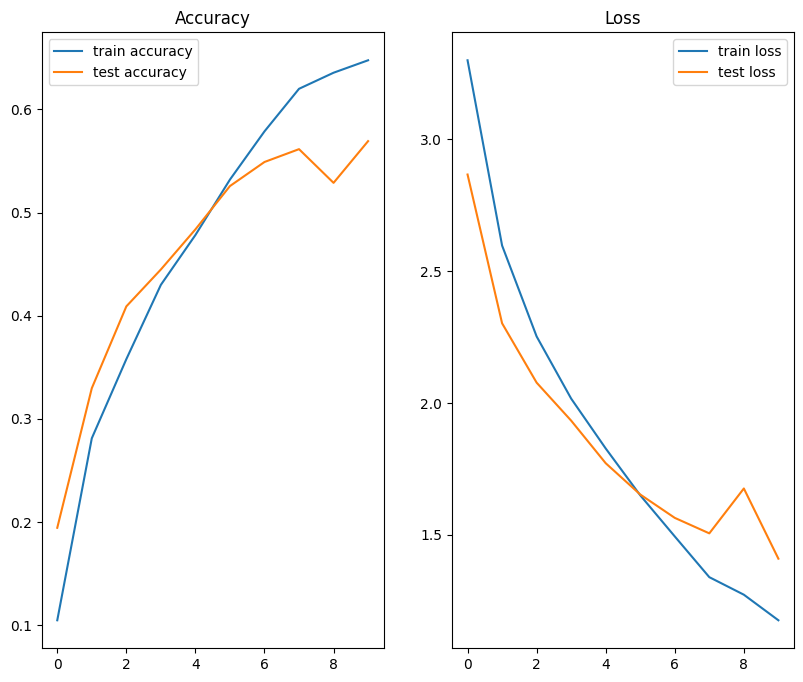

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='test loss')
plt.title('Loss')
plt.legend()
plt.show()

#### Точность двоичной классификации "кошки против собак" на тестовом датасете

In [ ]:
correct, total = 0, 0

for x, y in zip(X_test, y_test):
    y_pred = np.argmax(model.predict(np.expand_dims(x, axis=0), verbose=0), axis=1)
    correct_cats = y_pred in cats and y in cats
    correct_dogs = y_pred in dogs and y in dogs
    correct += correct_cats + correct_dogs
    total += 1

print('\nBinary classification accuracy: ', correct / total)


Binary classification accuracy:  0.9300155520995335


#### Сonfusion matrix

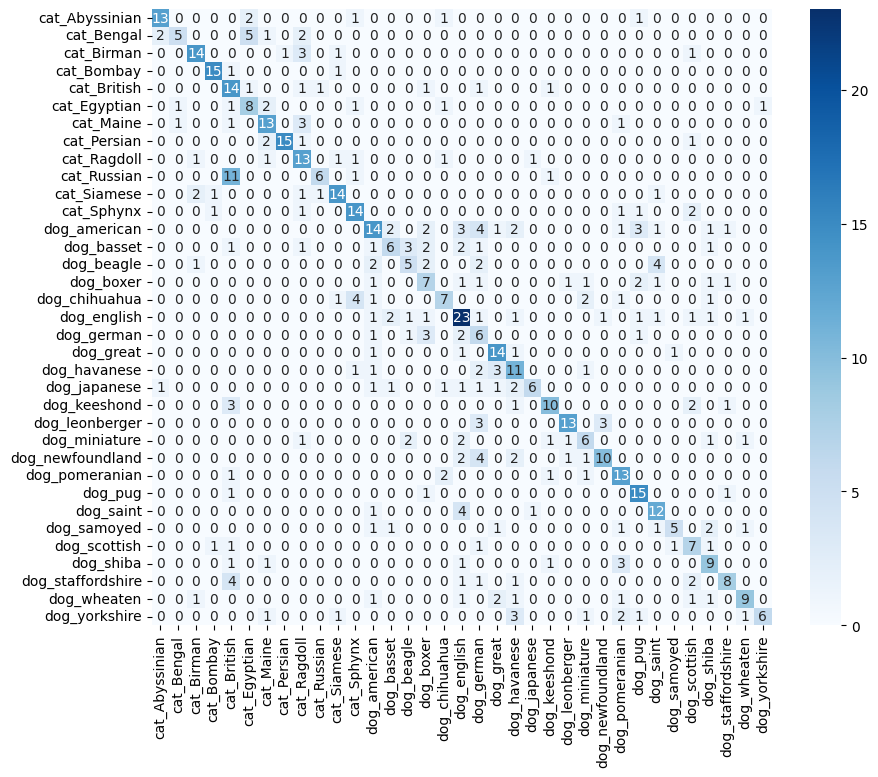

In [ ]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

y_real = np.array([])
y_pred = np.array([])

for x, y in zip(X_test, y_test):
    y_real = np.concatenate((y_real, y), axis=None)
    y_pred = np.concatenate((y_pred, np.argmax(model.predict(np.expand_dims(x, axis=0), verbose=0), axis=1)), axis=None)

conf_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=len(class_names))

df_cm = pd.DataFrame(conf_matrix, index=[i for i in class_names], columns=[i for i in class_names])
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.show()


In [ ]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 1s 51ms/step - loss: 1.4098 - accuracy: 0.5692 - top_3_accuracy: 0.8196


[1.4097551107406616, 0.5692068338394165, 0.8195956349372864]

## Вывод

Таким образом, путем обучения модели на датасете Pet Faces получили следующие результаты на валидационных данных: val_accuracy: 0.5692, val_top_3_accuracy: 0.8196, binary_classification_accuracy: 0.9300155520995335

Модель хорошо научилась различать кошек и собак, но при определении породы кошек и собак модель часто ошибается. Для увеличения точности требуется более крупный датасет.